In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
mpl.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\BrancaLab\\Desktop\\Yihan\\installers\\ffmpeg-7.0.1-essentials_build\\bin\\ffmpeg.exe'
from cmap import Colormap

import numpy as np
import SimpleITK as sitk
from scipy.signal import find_peaks, peak_widths
from scipy.stats import ttest_ind
from skimage.exposure import histogram
from skimage.restoration import denoise_bilateral
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.morphology import disk, rectangle, ellipse
from skimage.morphology import binary_dilation, binary_erosion
from skimage.morphology import opening, remove_small_holes, remove_small_objects
from skimage.transform import pyramid_expand
from skimage.measure import label, regionprops
from sklearn.linear_model import LinearRegression

from utils import *
from hu_utils import *

In [61]:
base_dir = 'Images\\DOD_KK_8589_DOD_8589_X-21-019\\'
idx_list = np.arange(500)
offset = 5  # shift between pre and post xenon slices

low_post_maps = []
high_post_maps = []
low_pre_maps = []
high_pre_maps = []

# trim = [200, 370, 115, 365]  # region of interest
trim = None

for idx in idx_list:

    path_low_post = get_scan_paths(base_dir, 'POST_LOW')[idx + offset]
    path_high_post = get_scan_paths(base_dir, 'POST_HIGH')[idx + offset]
    path_low_pre = get_scan_paths(base_dir, 'PRE_LOW')[idx]
    path_high_pre = get_scan_paths(base_dir, 'PRE_HIGH')[idx]
    
    low_post_hu = load_hu(path_low_post, trim)
    high_post_hu = load_hu(path_high_post, trim)
    low_pre_hu = load_hu(path_low_pre, trim)
    high_pre_hu = load_hu(path_high_pre, trim)
    
    low_post_maps.append(low_post_hu)
    high_post_maps.append(high_post_hu)
    low_pre_maps.append(low_pre_hu)
    high_pre_maps.append(high_pre_hu)
    
low_post_maps = np.array(low_post_maps)
high_post_maps = np.array(high_post_maps)

In [51]:
A = np.array([[-136.06575122, -792.2258608],
              [-97.71311417, -927.70512317]])
AINV = np.linalg.inv(A)
print(AINV)

[[-0.01900333  0.01622814]
 [ 0.00200158 -0.0027872 ]]


(-0.5, 511.5, 511.5, -0.5)

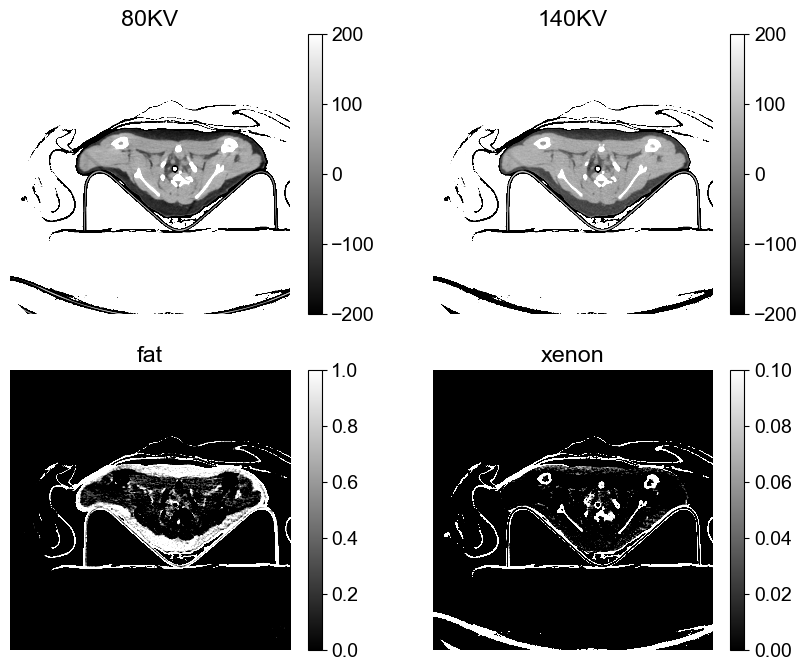

In [69]:
idx = 230
basic_mask = low_post_maps[idx, ...] > -900

sample_low = np.where(basic_mask, low_post_maps[idx, ...], 1000)
sample_high = np.where(basic_mask, high_post_maps[idx, ...], 1000)

sample_flat = np.vstack((sample_low.reshape(1, -1), sample_high.reshape(1, -1)))
decomp_flat = np.matmul(AINV, sample_flat)
material1 = decomp_flat[0].reshape(sample_low.shape)
material2 = decomp_flat[1].reshape(sample_low.shape)

plt.figure(figsize=(10, 8))

plt.subplot(221)
plt.imshow(sample_low, cmap='gray', vmin=-200, vmax=200)
plt.title('80KV')
plt.colorbar()
plt.axis('off')

plt.subplot(222)
plt.imshow(sample_high, cmap='gray', vmin=-200, vmax=200)
plt.title('140KV')
plt.colorbar()
plt.axis('off')

plt.subplot(223)
plt.imshow(material1, cmap='gray', vmin=0, vmax=1)
plt.title('fat')
plt.colorbar()
plt.axis('off')

plt.subplot(224)
plt.imshow(material2, cmap='gray', vmin=0, vmax=0.1)
plt.title('xenon')
plt.colorbar()
plt.axis('off')